![](imagenes/UC_FMRI.jpg)

---
---

***Andres Eduardo Aracena Rangel***

*Estudiante del programa del Magister en Física Médica*

---
---

El siguiente Script de Python forma parte del trabajo especial de grado.

&nbsp;
Con referencia:

- [Pagina oficial NIbabel](https://nipy.org/nibabel/index.html) 

Imagenes de fMRI extraidas de OpenNuero:
 
 - [ds002422](https://openneuro.org/datasets/ds002422/versions/1.1.0)
 
 ---
 Acronimos:

- CSF: Cerebrospinal Fluid (*líquido cefalorraquídeo*)
- GM: Gray Matter (*materia gris*)
- WM: White Matter (*materia blanca*)
---
NOTA:
Cuando indiquemos imagenes brain o mascaras brain, nos estamos refieriendo a las imagenes o mascaras de csf, wm, gm

# Extracción serie de tiempo promedio de mascaras csf, gm y wm

Del notebook **workflow_preprocesamiento_iterables_maskref.ipynb** se extrajo las mascaras para csf, gm y wm para tres umbrales *0.5, 0.9 y 0.99: y en el notebook **serie_tiempo_masks_4D_CSFgmWM.ipynb** se extrajo series de tiempo para las mascaras y sus umbrales.

En este notebook solo trabajaremos con las mascaras de csf, gm y wm pafa el umbral de 0.99, donde extraeremos su serie de tiempo promedio

&nbsp;
## Importamos librerias


In [1]:
import time # medir el tiempo de ejecución de nuestros programas
start = time.process_time()
inicio = time.time()

In [2]:
import os # El módulo os nos permite acceder a funcionalidades dependientes del Sistema Operativo
from os.path import join as opj # Este método concatena varios componentes de ruta con exactamente un separador de directorio(‘/’)

from nipype import SelectFiles

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from nilearn.plotting import plot_anat
%matplotlib inline

220720-02:07:46,604 nipype.utils WARNING:
	 A newer version (1.8.3) of nipy/nipype is available. You are using 1.7.0


/home/aracena/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Definimos parámetros

In [3]:
'''
Ruta del directorio de la data
'''
path_data = '/home/aracena/thesis_ds002422/' 

'''
Ruta donde reposa la imagen funcional preprocesada con bet
'''
path_fmri = opj(path_data,'02_fase1_extraccion_brain_fmri_prepro','output')

'''
Ruta mascaras brain
'''
path_brain = opj(path_data,'01_fase1_extraccion_mask_brain','output','datasink','masks_brain')


'''
Ruta donde reposan las imagenes de referencia de los cortes anatomicos
'''
path_ref = opj(path_data,'03_fase2_extraccion_series_tiempo_brain', 'imagenes')


'''
lista de tejidos a procesar
'''
tejido = ['mask_csf', 'mask_gm', 'mask_wm']

        
'''
Ingrese el umbral que desea extraer (se extrajeron tres mask brain para tres umbrales distintos)
'''
umbral_sel = '0.95'

'''
Ruta donde se guardaran los resultados
'''
path_out = opj(path_data,'03_fase2_extraccion_series_tiempo_brain','output', umbral_sel)

# Ruta donde se guardara archivos csv
path_csv = opj(path_out,'archivos_csv')

# Ruta donde se guardaran las imagenes png
path_png = opj(path_out,'archivos_png')

'''
Creamos la carpeta de salida
'''
os.system('mkdir -p %s'%path_out)
os.system('mkdir -p %s'%path_csv)
os.system('mkdir -p %s'%path_png)

'''
Creamos la carpeta de salida para tablas
'''
path_out_DF = opj(path_out,'tablas_proyecto')
os.system('mkdir -p %s'%path_out_DF);

## Definimos funciones

### Función para extraer los atributos de la(s) imagen(es)

In [4]:
'''
Función para extraer los atributos de la(s) imagen(es).

Inputs:

- img: Diccionario con las imagenes nifti

Output:

df_atri: Dataframe con los principales atributos de las imagenes contenidas en el diccionario 'img'
'''

def atributo_img(img):
    import pandas as pd
    lista_img = list(img.keys()) # Creamos una lista con las claves del diccionario

    df_atri = pd.DataFrame()
    df_atri.index = ['forma', 'dimension', 'orientacion', '', 'x_img', 'y_img' , 'z_img', 'volumenes_(N)', 'voxel_size_(mm)', 
                       'TR_(s)', 'tipo_dato', 'numero_voxels','min_img', 'max_img']
    
    for i, ima in enumerate(lista_img):
        lista_atri = []
        #cargamos el header de la imagen
        header_img = img[ima].header
        
        # Forma y dimensión de la imágen
        forma = header_img.get_data_shape() 
        lista_atri.append(str(forma))
        lista_atri.append(len(forma))
        
        # Orientacion de la imágen
        orientacion = nib.orientations.aff2axcodes(img[ima].affine)
        lista_atri.append(orientacion)

        # x, y, z y volumenes
        ejes=[]
        for i in range(len(orientacion)):
            tam = img[ima].shape[i]
            ori = str(orientacion[i])
            if  ori == 'L'or ori == 'R':
                x_img = tam
                a = 'x'

            elif ori == 'A' or ori == 'P':
                y_img = tam
                a = 'y'

            elif ori == 'I'or ori == 'S':
                z_img = tam
                a = 'z'
                
            ejes.append(a)
        
        # Agregamos a la lista de atributos forma, x, y, z
        lista_atri.append(ejes)
        lista_atri.append(x_img)
        lista_atri.append(y_img)
        lista_atri.append(z_img)
        
        # Agregamos volumes a la lista de atributos 
        if len(forma) == 4:
            lista_atri.append(forma[-1])
        else:
            lista_atri.append('1')

        # Tamaño del voxel
        tavo = header_img.get_zooms()[0:3]
        
        tamvox=[]
        for i in range(len(tavo)):
            tamvox.append(round(tavo[i],3))
            
        lista_atri.append(tamvox) 
        
        # Tiempo de exploración
        if len(header_img.get_zooms()) == 4:
            lista_atri.append(header_img.get_zooms()[-1])
        else:
            lista_atri.append('---')     
        
        
        #lista_atri.append(header_img.get_zooms()[-1])   # Tiempo de exploración
        lista_atri.append(header_img.get_data_dtype())   # Tipo de datos numérico
        lista_atri.append(img[ima].get_fdata().size) # Número de elementos de la matriz
        lista_atri.append(round(img[ima].get_fdata().min(),2)) # Valor minimo de la imágen
        lista_atri.append(round(img[ima].get_fdata().max(),2)) # Valor maximio de la imágen
        
        # Creamos DF de atributos de la imagen
        df_at = pd.DataFrame()
        df_at = pd.DataFrame(lista_atri)
        df_at.columns = [ima]
        df_at.index = df_atri.index
        #display(df_at)

        # Unimos las DF
        df_atri = pd.merge(df_atri, df_at,
                           right_index=True,left_index=True)
    return df_atri

### Funcion para visualizar y guardar los cortes anatomicos sobre un voxel

In [5]:
'''
Función para generar la visualización de los cortes anatómico de varias imágenes (hasta cuatro) 

Inputs:

- img: Diccionario con las imágenes nifti
- vol: Volumen donde se desea visualizar los cortes anatómicos
- vox: Posición i,j,k del voxel sobre el cual se proyectarán los cortes
#- nom_img = nombre de la imagen con que se desea visualizar y guardar

Outputs:
- plot de los diferentes cortes anatómicos sobre un voxel de las imágenes ingresadas en 'img'
'''

def visual_cortes_ana(img, vol, voxel):
    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
   
    # Creamos una lista con las claves del diccionario ingresado
    lista_img = list(img.keys())

    corte_sag = {}
    corte_cor = {}
    corte_axi = {}
    datos_img = {}
    x_cor = {}
    y_cor = {}
    z_cor = {}
    nomb_ori={}
    for i, ima in enumerate(lista_img):
        # Orientacion de la imágen
        orientacion = nib.orientations.aff2axcodes(img[ima].affine)
        # creamos un nombre para la grafica
        a = ','.join(orientacion)
        nomb_ori[ima] = '('+ a +')'
        
        #cargamos datos de la imagen
        datos_img[ima] = img[ima].get_fdata()
        ta = len(datos_img[ima].shape)
        if ta == 4:
            datos_img[ima] = datos_img[ima][...,vol]
        else:
            datos_img[ima] = datos_img[ima][...]

        #se extraen valores x, y, z del voxel ingresado y cortes segun posición anatómica
        for j in range(len(orientacion)):
            ori = str(orientacion[j])

            if  ori == 'L'or ori == 'R':
                x_cor[ima] = voxel[j]
                
                # corte segun posición anatómica
                if j == 0:
                    corte_sag[ima] = datos_img[ima][x_cor[ima],:,:]
                elif j == 1:
                    corte_sag[ima] = datos_img[ima][:,x_cor[ima],:]
                elif j == 2:
                    corte_sag[ima] = datos_img[ima][:,:,x_cor[ima]]

            elif ori == 'A' or ori == 'P':
                y_cor[ima] = voxel[j]
                
                # corte segun posición anatómica
                if j == 0:
                    corte_cor[ima] = datos_img[ima][y_cor[ima],:,:]
                elif j == 1:
                    corte_cor[ima] = datos_img[ima][:,y_cor[ima],:]
                elif j == 2:
                    corte_cor[ima] = datos_img[ima][:,:,y_cor[ima]]

            elif ori == 'I'or ori == 'S':
                z_cor[ima] = voxel[j]
                
                # corte segun posición anatómica
                if j == 0:
                    corte_axi[ima] = datos_img[ima][z_cor[ima],:,:]
                elif j == 1:
                    corte_axi[ima] = datos_img[ima][:,z_cor[ima],:]
                elif j == 2:
                    corte_axi[ima] = datos_img[ima][:,:,z_cor[ima]]
    
    # Definimos estilo de letra para la grafica
    font1 = {'fontsize':18, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}
    
    if (len(lista_img))==1:
        #Graficamos
        nom = lista_img[0] + '\n' + nomb_ori[lista_img[0]]

        fig, axes = plt.subplots(1,3, figsize=(15, 15))
        fig.suptitle(nom, fontweight ="bold", fontsize = 22, color = 'tab:blue')
        axes[0].imshow(corte_sag[ima], cmap = 'gray')
        axes[1].imshow(corte_cor[ima], cmap = 'gray')
        axes[2].imshow(corte_axi[ima], cmap = 'gray')
        for i in range(3):
            axes[i].axis('off')

        # Titulos de las graficas
        titulo =['Corte Sagital: '+ str(x_cor[ima]) + '\n', 
                 'Corte Coronal: '+ str(y_cor[ima]) + '\n',
                 'Corte Axial: '+ str(z_cor[ima]) + '\n']

        for i, title in enumerate(titulo):
            axes[i].set_title(title, fontdict=font2)

        plt.subplots_adjust(#left=0.5,
                        #bottom=0.5, 
                        #right=0.7,
                        hspace=0.3,
                        top=1.26)
        fig.patch.set_facecolor('xkcd:white')
        plt.show()
    
    else:
        # Graficamos
        fig, axes = plt.subplots(3, len(lista_img),figsize=(20, 20))
        for i, im in enumerate(lista_img):
            axes[0,i].imshow(corte_sag[im], cmap = 'gray')
            axes[1,i].imshow(corte_cor[im], cmap = 'gray')
            axes[2,i].imshow(corte_axi[im], cmap = 'gray')

        
            # Identificamos los cortes
            titulo =['Corte Sagital: '+ str(x_cor[im]) + '\n', 
                     'Corte Coronal: '+ str(y_cor[im]) + '\n',
                     'Corte Axial: '+ str(z_cor[im]) + '\n']

            for j, title in enumerate(titulo):
                axes[j,i].xaxis.set_label_position('top')
                axes[j,i].set_xlabel(title, fontdict=font2)
            

        # Titulos que que identifica la imagen y la orientacion
        for i,im in enumerate(lista_img):
            axes[0,i].set_title((im+'\n'+nomb_ori[im]+'\n'), 
                                fontdict=font1)
        
        #for j in range(3):
            #for i in range(2):
                #axes[j,i].axis('off')

    
        plt.subplots_adjust(#left=0.5,
                            #bottom=0.5, 
                            #right=0.7,        
                            #hspace=0.3,
                            top=0.91)
    plt.show()
    
    # cargamos imagen de referencia de los cortes anatomicos
    img_cor_sag = mpimg.imread(opj(path_ref,'corte_sagital.png'))
    img_cor_cor = mpimg.imread(opj(path_ref,'corte_coronal.png'))
    img_cor_axi = mpimg.imread(opj(path_ref,'corte_axial.png'))

    img_cor = [img_cor_sag,img_cor_cor,img_cor_axi]

    fig, axes = plt.subplots(1,3, figsize=(2,2))
    for i,imco in enumerate(img_cor):
        axes[i].imshow(img_cor[i])
        axes[i].axis('off')

    # para cambiar el espacio entre las subtramas de Matplotlib
    plt.subplots_adjust(left=0, 
                        bottom=0.1,  
                        right=7,  
                        top=0.9,  
                        wspace=1,  
                        hspace=0.4)
    #fig.tight_layout()
    fig.patch.set_facecolor('xkcd:white')
    plt.plot()

### Funcion que recorre los voxels y extrae series de tiempos: Imagenes 4D o mascaras binarias

In [6]:
'''
Función que recorre voxel a voxel y extrae sus series de tiempo de las imagens 4D y de las mascaras binarias 
o su convulion con imagenes 4D. Se requiere input:

- datos_img = datos de la imagen 4D a procesar
- binaria = si es una mascara o convolución, su valor es de 1
            si es una imagen anatomica o funcional, su valor es 0
'''

def vox_all(datos_img, binaria):    
    import numpy as np
    
    x_img=datos_img.shape[2] 
    y_img=datos_img.shape[1] 
    z_img=datos_img.shape[0] 
    tf=datos_img.shape[3]
    
    # creamos listas para luego ser guardadas en DF
    pos_vox = [] #posicion dl voxel
    ser_vox = [] #series de tiempo
    ser_vox_nor = [] #series de tiempo normalizada
    ser_etiq = [] #etiquetas de los voxels
    #voxel_norm_glob = []
    #mean = []    
      
    n = 0
    p = 0
    etiqueta = 0
    for k in range(z_img):
        for j in range(y_img):
            for i in range(x_img):                
                val_eva = datos_img[k, j, i, 0] #valor del voxel en la posicion x,y,z
                
                if val_eva == 0:
                    if binaria == 1:
                        n = n
                        etiqueta += 1
                        continue
                
                # lista de la posición del voxel y su etiqueta
                pos_vox.append([etiqueta, k, j, i])
                                
                #lista de las series de tiempo de cada voxel                
                valu_voxel = datos_img[k, j, i, :]
                ser_vox.append(valu_voxel)
                
                # normalizamos
                dividendo = (np.amax(valu_voxel)-np.amin(valu_voxel))
                if dividendo == 0:
                    #print(i,j,k)
                    w = np.zeros(tf,dtype='float')
                    ser_vox_nor.append(w)
                    #mean.append(mean_voxel)
                    p = p+1
                    n = n+1
                else:                    
                    ser_vox_nor.append((valu_voxel-np.amin(valu_voxel))/dividendo)     
                    #mean.append(mean_voxel)
                    n = n+1
                
                # lista de la etiqueta del voxels recorrido
                ser_etiq.append(etiqueta)
                etiqueta += 1
                
    
    # Creamos DF de la posición del voxel
    df_pos_vox = pd.DataFrame(pos_vox)
    df_pos_vox.columns = ['voxel/serie', 'z', 'y', 'x']
    
    # Creamos DF de las series de tiempo
    df_ser_vox = pd.DataFrame(ser_vox)
    df_ser_vox.index = [ser_etiq]
    
    # Creamos DF de las series de tiempo normalizadas
    df_ser_vox_nor = pd.DataFrame(ser_vox_nor)
    df_ser_vox_nor.index = [ser_etiq]
            
    return df_pos_vox, df_ser_vox, df_ser_vox_nor, n, p

### Función para graficar series de tiempo

In [7]:
'''
Función grafica las series de tiempo de una DF introducida. Se requiere input:

- df_data = Dataframe que contiene las series de tiempo
- name_save = nombre con que desea guardar el grafico
'''

def plot_series_time(df_data, name_save): 
    # Creamos una lista con las claves del diccionario ingresado
    tejido = list(df_data.keys())
    # definimos una ventana
    vent_min = 50
    vent_max = 75


    font1 = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}
    titulo = "Promedio de las series de tiempo csf y wm normalizados"

    fig, ax = plt.subplots(figsize = (17,8))
    for i,tisue in enumerate(tejido):
        if i == 1:
            ax.plot(df_data[tisue], linewidth=2, label=tisue)
        else:           
            ax.plot(df_data[tisue], '--.', linewidth=2, label=tisue)

    ax.legend()
    ax.set_xlabel('Tiempo',fontdict=font1)
    ax.set_ylabel('Señal fMRI',fontdict=font1)
    ax.set_title(titulo, fontdict = font2)
    ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
    ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    ax.axvspan(vent_min,vent_max, alpha=0.3, facecolor='y')

    plt.savefig(opj(path_png, name_save))

## Cargamos imagen funcional preprocesada con bet y datos de la  imagen funcional

In [8]:
img_func = 'fmri_prepro_bet.nii.gz'
img_func_orig = nib.load(opj(path_fmri,img_func)) # Cargamos imagen nifti
datos_func_orig = img_func_orig.get_fdata()       # Cargamos datos de la imagen
datos_func_orig.shape

(62, 62, 44, 196)

## Diccionario: Crear diccionario general de la imagenes y datos a procesar

El objetivo de guardar las imagenes y datos de las imagenes a procesar (imagenes funcional y mascaras brain) es para luego poder utilizar los respectivos datos de manera sencilla en bucles.
Se crea los siguientes diccionario general:

- 'img': para guaradar las imagenes a procesar
- 'datos_img': para guardar los datos de las imagenes a procesar

### Diccionario: Agregar imagen y datos de la imagen funcional al diccionario general

In [9]:
img = {'func_prepro_bet': img_func_orig}
datos_img = {'func_prepro_bet' : datos_func_orig}

In [10]:
type(img)

dict

## Cargamos imagen y datos de la imagenes de las mascaras brain

### Interfaz SelectFiles - mascaras brain

En esta oprtunidad, trabajaremos con interfaces y no con nodos, ya que queremos trabajar directamente y visualizar las mascaras.

Extramos las rutas de las mascaras para los umbrales previamente calculo en el notebook **01_fase1_extraccion_mask_brain**

In [11]:
# La entrada template indica la plantilla de cadena que debe coincidir en el directorio indicado a buscar
templates = {'mask_brain': 'mask_ext_*/threshold_{umbral}/fmri_rest_prepro.nii.gz'}
       
selectfiles = SelectFiles(templates)


'''
Inputs
- Ubicación de la carpeta del conjunto de datos
- Cadenas de marcador de posición {}
'''
# La entrada base_directory indica en que directorio buscar
selectfiles.inputs.base_directory = path_brain

#Ingresamos la(s) cadena(s) de marcador de posición {} con valores
selectfiles.inputs.umbral = umbral_sel

#selectfiles.inputs.tejido = [tejido]
#get_mask_ext.iterables = ('mask_ext', mask_ext)

# ejecutamos 
brain_mask = selectfiles.run().outputs

In [12]:
brain_mask


mask_brain = ['/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_csf/threshold_0.95/fmri_rest_prepro.nii.gz', '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_gm/threshold_0.95/fmri_rest_prepro.nii.gz', '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_wm/threshold_0.95/fmri_rest_prepro.nii.gz']

### Diccionarios para los mascaras tejido-umbrales

In [13]:
mask = dict(zip(tejido,brain_mask.mask_brain))
print('mask\n', mask)

mask
 {'mask_csf': '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_csf/threshold_0.95/fmri_rest_prepro.nii.gz', 'mask_gm': '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_gm/threshold_0.95/fmri_rest_prepro.nii.gz', 'mask_wm': '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_wm/threshold_0.95/fmri_rest_prepro.nii.gz'}


### Diccionario: Cargamos imagenes nifti de mascaras

In [14]:
lista_brain = list(mask.keys()) # extraemos una lista de las mascaras

img_mask = {}
for i, tisue in enumerate(lista_brain):
    img_mask[tisue] = nib.load(mask[tisue])

print(img_mask['mask_csf'].shape)
print(img_mask['mask_wm'].shape)
print(img_mask['mask_gm'].shape)


(62, 62, 44, 196)
(62, 62, 44, 196)
(62, 62, 44, 196)


In [15]:
img_mask

{'mask_csf': <nibabel.nifti1.Nifti1Image at 0x7fa7082beb50>,
 'mask_gm': <nibabel.nifti1.Nifti1Image at 0x7fa7082be5b0>,
 'mask_wm': <nibabel.nifti1.Nifti1Image at 0x7fa7082be070>}

### Diccionario: cargamos datos de mascaras

In [16]:
datos_img_mask = {}
for i, tisue in enumerate(lista_brain):
    datos_img_mask[tisue] = img_mask[tisue].get_fdata()

print(datos_img_mask['mask_wm'].shape)

(62, 62, 44, 196)


## Diccionario: Agregamos las imagenes y datos de las imagenes da las mascaras brain al diccionario general

In [17]:
'''
Para añadir los pares clave-valor de un diccionario a otro, empleamos el método update().
'''

img.update(img_mask)
datos_img.update(datos_img_mask)

In [18]:
print(img)

{'func_prepro_bet': <nibabel.nifti1.Nifti1Image object at 0x7fa7082c6af0>, 'mask_csf': <nibabel.nifti1.Nifti1Image object at 0x7fa7082beb50>, 'mask_gm': <nibabel.nifti1.Nifti1Image object at 0x7fa7082be5b0>, 'mask_wm': <nibabel.nifti1.Nifti1Image object at 0x7fa7082be070>}


## Extraemos los atributos de las imagen(es)

In [19]:
'''
Creamos diccionario de las imagenes (img) y datos de imagenes (datos_img)
'''
# Ya los diccionario img y datos_img estan creados en la lineas anteriores

'''
Ejecutamos la función atributo_img()
'''
atributo = atributo_img(img=img)
atributo

,func_prepro_bet,mask_csf,mask_gm,mask_wm
forma,"(62, 62, 44, 196)","(62, 62, 44, 196)","(62, 62, 44, 196)","(62, 62, 44, 196)"
dimension,4,4,4,4
orientacion,"(P, S, R)","(P, S, R)","(P, S, R)","(P, S, R)"
,"[y, z, x]","[y, z, x]","[y, z, x]","[y, z, x]"
x_img,44,44,44,44
y_img,62,62,62,62
z_img,62,62,62,62
volumenes_(N),196,196,196,196
voxel_size_(mm),"[4.0, 4.0, 4.0]","[4.0, 4.0, 4.0]","[4.0, 4.0, 4.0]","[4.0, 4.0, 4.0]"
TR_(s),3.56,3.56,3.56,3.56


In [20]:
atributo['func_prepro_bet']['x_img']

44

## Visualizamos los cortes anatomicos de las imagenes

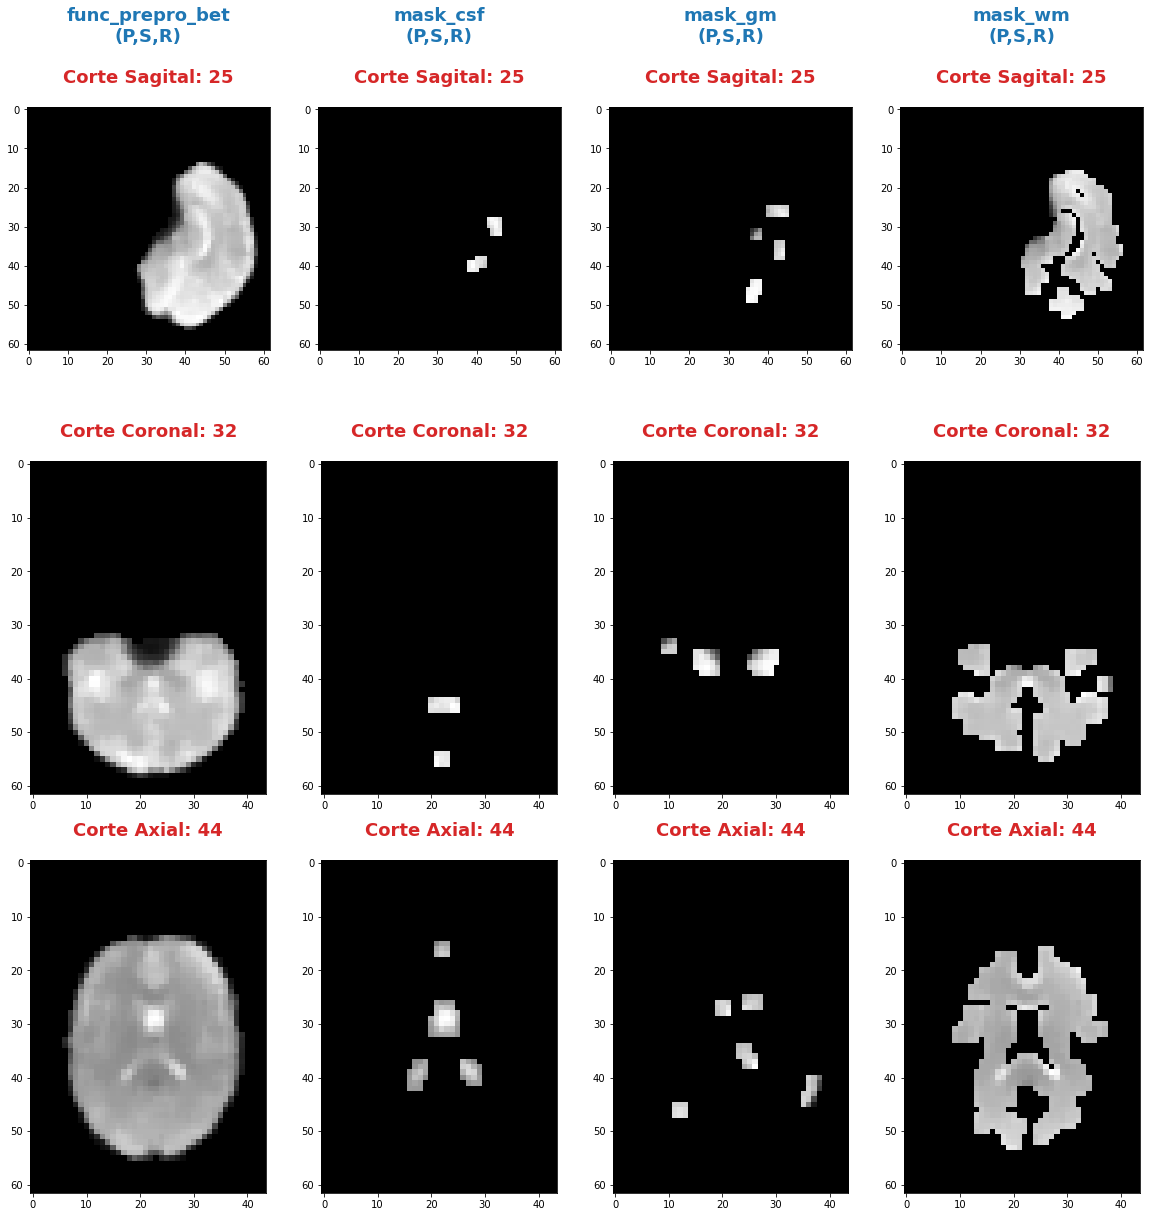

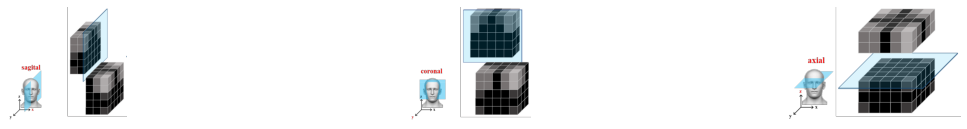

In [21]:
visual_cortes_ana(img= img,
                  vol= 40, 
                  voxel= (32,44,25))

### Visualizamos con plot_anat

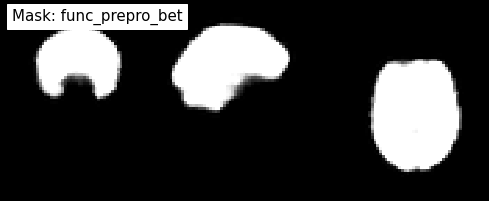

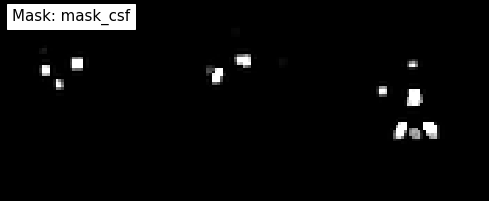

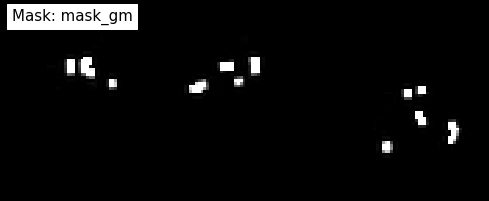

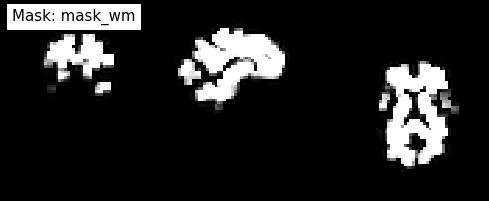

In [22]:
# elegimos un volumen
vol = 40

lista_vis = list(img.keys()) # extraemos una lista de las mascaras

vol_vis = {}
for i, mas in enumerate(lista_vis):
    vol_vis[mas] = img[mas].slicer[...,vol]

for i, mas in enumerate(lista_vis):
    plot_anat(vol_vis[mas], title='Mask: '+mas, 
              cut_coords=(10,10,10), display_mode='ortho', 
              dim=-1, draw_cross=False, annotate=False);

## Extraemos todas las series de tiempo de la imagen funcional.

### Aplicamos funcion vox_all

In [23]:
'''
Ejecutamos la función vox_all
'''
res = vox_all(datos_img=datos_img['func_prepro_bet'], 
              binaria=0)

'''
Cargamos la posición de los voxels
'''
vox_pos_func = res[0]

'''
Cargamos los valores de los voxels
'''
voxel_val_func = res[1]

'''
Cargamos los valores de los voxels normalizado
'''
voxel_norm_func = res[2]

'''
Cargamos el numero de voxels en la masacara
'''
vox_num_func= res[3]

print('--------------------------------------------\n' )
print('numero de voxels de la imagen funcional:\n', vox_num_func)

'''
Cargamos el numero de voxels donde la series es de cero
'''

ceros_func = res[4]
print('\n-------------------------------------------\n')
print('cantidad de voxel series ceros:\n',ceros_func)
print('\n-------------------------------------------')

--------------------------------------------

numero de voxels de la imagen funcional:
 169136

-------------------------------------------

cantidad de voxel series ceros:
 146180

-------------------------------------------


In [24]:
pd.options.display.max_columns = 15 # para mejorar la visualización del DataFrame

voxel_val_func

,0,1,2,3,4,5,6,...,189,190,191,192,193,194,195
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Ejemplo de esta imagen donde la serie es de cero

In [25]:
serie_prueba = datos_func_orig[4,32,0,:]
df_serie_prueba = pd.DataFrame(serie_prueba)
df_serie_prueba

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
191,0.0
192,0.0
193,0.0
194,0.0


In [26]:
df_serie_prueba.describe()

,0
count,196.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


### Guardamos resultados en formato csv

In [27]:
'''
Valores voxel_val
'''
df_voxel_val_func = voxel_val_func.T

name = 'serie_tiempo_all_func.csv'
#df = pd.DataFrame(df_func_orig)
df_voxel_val_func.to_csv(opj(path_csv,name),index = False)

'''
Valores voxel_norm
'''
df_voxel_val_func_norm = voxel_norm_func.T

name = 'serie_tiempo_all_func_norm.csv'
df_voxel_val_func_norm.to_csv(opj(path_csv,name),index = False)

'''
La posición de los voxels
'''
name = 'pos_vox_func.csv'
vox_pos_func.to_csv(opj(path_csv,name),index = False)

##  Ejecutamos la función vox_all a las mascaras

In [28]:
# creamos lista para solo iterar sobre las mascaras

lista_brain = list(mask.keys()) # extraemos una lista de las mascaras

#creamos diccionarios vacios para guardar resultados de vox_all
res = {}
vox_pos = {}
voxel_norm = {}
voxel_val = {}
vox_num_mask = {}
df_num_vox = pd.DataFrame()


binaria = 1

for i, tisue in enumerate(lista_brain):
    '''
    Ejecutamos la función vox_all
    '''
    res = vox_all(datos_img=datos_img[tisue], 
                  binaria=1)
    
    '''
    Cargamos la posición de los voxels
    '''
    vox_pos[tisue] = res[0]
    
    '''
    Cargamos los valores de los voxels
    '''
    voxel_val[tisue] = res[1]
        
    '''
    Cargamos los valores de los voxels normalizado
    '''
    voxel_norm[tisue] = res[2]

    '''
    Cargamos el numero de voxels en la y creamos DF
    '''
    vox_num_mask[tisue] = res[3]
    df_num_vox[tisue] = [res[3]]
    #print('numero de voxels en la mascara csf:\n', vox_num_mask)

In [29]:
df_num_vox_mask = df_num_vox.T
df_num_vox_mask.columns = ['numero_voxels_mask']
df_num_vox_mask

,numero_voxels_mask
mask_csf,664
mask_gm,1794
mask_wm,9439


### Visualizamos las series de tiempo

In [30]:
pd.options.display.max_columns = 12

voxel_val['mask_csf'].T

,42789,42790,42791,42833,42834,42835,...,119218,119219,119220,119224,119225,119226
0,147.668701,199.851395,321.464417,319.859619,390.075043,485.286591,...,575.245911,564.928162,563.222595,571.135742,569.495667,573.659790
1,147.734985,203.295837,316.090210,320.602753,394.869293,489.250885,...,576.844482,574.859253,572.265747,574.809692,565.620789,569.487976
2,147.813690,198.290558,318.719666,324.457642,391.678802,484.849060,...,571.221802,582.090027,579.156067,568.527588,569.592651,570.382019
3,148.630875,207.636703,311.952423,325.447235,387.747406,489.182068,...,562.674438,564.800537,562.293640,570.185669,564.723206,571.315186
4,148.653290,203.587326,304.501617,329.378143,391.722839,488.992188,...,570.756592,564.414001,564.004456,575.846069,566.695435,577.148010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,141.190781,206.106812,308.748840,318.514404,415.739349,496.409668,...,567.523254,567.580322,570.030457,570.975403,568.758972,574.168945
192,148.696869,212.194748,314.824097,325.573364,412.295959,502.475403,...,575.559021,570.799500,576.565796,573.521729,570.436768,570.730591
193,152.130447,211.498489,313.927216,315.044403,415.206024,503.547485,...,582.249146,576.852112,569.587463,565.593323,567.328613,574.088501
194,146.669983,214.301300,301.381012,306.016785,417.359467,507.997894,...,571.097778,570.077942,573.925476,576.993652,574.053040,576.496826


#### Calculamos los tiempos de observación

El tiempo de observación esta dado por

$\tau_N = \tau_0+(N-1)\cdot TR$

Con $N$ igual al numero de observaciones/volumenes y TR el tiempo de repetición. Si $\tau_0$ es igual al origen tendremos


In [31]:
# Extraemos el indice y sumamos 1, para inidcar la cantidad de observaciones
a=voxel_val['mask_csf'].T
indice = a.index + 1

In [32]:
tau_0 = 0
TR = atributo['func_prepro_bet']['TR_(s)']
val_tiempo = []
for i in range (len(indice)):
    N=i+1
    val_tiempo.append(round(tau_0+(N-1)*TR,2))                     


df_val_tiempo = pd.DataFrame()
df_val_tiempo['observacion/volumen (N)'] = indice
df_val_tiempo['valor $\\tau_N$' +'  (s)']= val_tiempo
df_val_tiempo.index = indice
df_val_tiempo.index.name = 'tiempo ($\\tau_N$)'
df_val_tiempo

,observacion/volumen (N),valor $\tau_N$ (s)
tiempo ($\tau_N$),,
1,1,0.00
2,2,3.56
3,3,7.12
4,4,10.68
5,5,14.24
...,...,...
192,192,679.96
193,193,683.52
194,194,687.08


#### Damos un formato a las DF solo para ser extraidas a un documento

In [33]:
#df = {}
pd.options.display.max_columns = 8

for i, tisue in enumerate(tejido):
    df_1 = voxel_val[tisue].copy()
    df_1 = df_1.T
    df_1

    no_col = df_1.columns.values

    nomb_colum = []

    for i, nc in enumerate(no_col):
        nomb_colum.append(nc[0])
    
    new_index = df_1.index+1

    header = pd.MultiIndex.from_product([['Series de tiempo: '+tisue], nomb_colum],
                                        names=[' ','tiempo ($\\tau_N$)'])
    df_1 = pd.DataFrame(df_1.values, columns=header, index=new_index)

    display(df_1.round(3))

Series de tiempo: mask_csf                             ...  \
tiempo ($\tau_N$)                     42789    42790    42791    42833   ...   
1                                    147.669  199.851  321.464  319.860  ...   
2                                    147.735  203.296  316.090  320.603  ...   
3                                    147.814  198.291  318.720  324.458  ...   
4                                    148.631  207.637  311.952  325.447  ...   
5                                    148.653  203.587  304.502  329.378  ...   
..                                       ...      ...      ...      ...  ...   
192                                  141.191  206.107  308.749  318.514  ...   
193                                  148.697  212.195  314.824  325.573  ...   
194                                  152.130  211.498  313.927  315.044  ...   
195                                  146.670  214.301  301.381  306.017  ...   
196                                  140.227  208.587  303.595  295.467  ...   

                                                       
tiempo ($\tau_N$)   119220   119224   119225   119226  
1                  563.223  571.136  569.496  573.660  
2                  572.266  574.810  565.621  569.488  
3                  579.156  568.528  569.593  570.382  
4                  562.294  570.186  564.723  571.315  
5                  564.004  575.846  566.695  577.148  
..                     ...      ...      ...      ...  
192                570.030  570.975  568.759  574.169  
193                576.566  573.522  570.437  570.731  
194                569.587  565.593  567.329  574.089  
195                573.925  576.994  574.053  576.497  
196                568.996  571.335  571.035  575.821  

[196 rows x 664 columns]

Series de tiempo: mask_gm                             ...  \
tiempo ($\tau_N$)                    69984    69985    69986    70028   ...   
1                                   482.692  483.876  523.863  500.586  ...   
2                                   490.439  490.441  517.637  499.352  ...   
3                                   485.500  484.314  512.509  502.541  ...   
4                                   476.901  484.135  516.711  492.174  ...   
5                                   485.045  488.924  517.883  494.483  ...   
..                                      ...      ...      ...      ...  ...   
192                                 479.273  482.000  520.090  495.017  ...   
193                                 484.101  482.913  516.417  497.961  ...   
194                                 484.148  482.442  520.879  497.371  ...   
195                                 484.835  488.470  519.455  500.314  ...   
196                                 484.571  487.482  511.344  499.337  ...   

                                                       
tiempo ($\tau_N$)   138013   138054   138055   138056  
1                  566.739  604.856  611.386  608.636  
2                  565.928  607.191  616.315  612.303  
3                  560.519  603.756  613.509  611.362  
4                  577.032  596.944  603.076  608.359  
5                  553.957  606.034  615.233  603.549  
..                     ...      ...      ...      ...  
192                569.794  598.264  613.220  609.639  
193                565.766  603.288  609.639  608.893  
194                564.594  602.538  611.554  612.416  
195                568.227  604.447  611.405  607.778  
196                580.032  606.760  614.058  614.360  

[196 rows x 1794 columns]

Series de tiempo: mask_wm                             ...  \
tiempo ($\tau_N$)                    45521    45522    45523    45565   ...   
1                                   558.510  540.997  541.390  612.871  ...   
2                                   557.311  531.427  531.750  614.957  ...   
3                                   553.042  542.497  542.753  612.460  ...   
4                                   556.084  536.858  537.048  609.126  ...   
5                                   552.461  535.621  535.745  614.711  ...   
..                                      ...      ...      ...      ...  ...   
192                                 561.972  529.631  535.688  614.774  ...   
193                                 557.835  536.516  541.599  609.854  ...   
194                                 559.802  531.377  534.837  609.735  ...   
195                                 555.848  542.342  533.729  616.522  ...   
196                                 553.873  537.617  535.469  618.154  ...   

                                                       
tiempo ($\tau_N$)   149135   149177   149178   149179  
1                  692.887  705.566  682.213  680.012  
2                  688.677  699.487  686.829  682.570  
3                  695.907  697.279  682.359  680.454  
4                  690.544  697.413  687.366  683.098  
5                  691.491  704.485  686.239  679.217  
..                     ...      ...      ...      ...  
192                688.721  699.697  680.160  678.870  
193                687.257  702.897  682.628  680.962  
194                689.940  694.145  685.434  684.456  
195                690.554  694.869  688.941  687.569  
196                693.699  699.624  685.680  679.593  

[196 rows x 9439 columns]

### Visualizamos las series de tiempo normalizadas

In [34]:
voxel_norm['mask_csf'].T

,42789,42790,42791,42833,...,119220,119224,119225,119226
0,0.648482,0.465610,0.696788,0.561077,...,0.326825,0.561927,0.516017,0.585941
1,0.650302,0.557280,0.593478,0.577106,...,0.668015,0.744916,0.311767,0.331785
2,0.652463,0.424070,0.644025,0.660252,...,0.927980,0.432023,0.521129,0.386252
3,0.674902,0.672808,0.513937,0.681597,...,0.291776,0.514607,0.264454,0.443103
4,0.675517,0.565038,0.370708,0.766383,...,0.356324,0.796534,0.368413,0.798452
...,...,...,...,...,...,...,...,...,...
191,0.470607,0.632092,0.452353,0.532062,...,0.583679,0.553941,0.477185,0.616960
192,0.676714,0.794115,0.569139,0.684318,...,0.830251,0.680766,0.565624,0.407488
193,0.770995,0.775585,0.551899,0.457217,...,0.566965,0.285876,0.401789,0.612060
194,0.621058,0.850179,0.310720,0.262500,...,0.730635,0.853692,0.756242,0.758780


#### Damos un formato a las DF solo para ser extraidas a un documento

In [35]:
for i, tisue in enumerate(tejido):
    df_2 = voxel_norm[tisue].copy()
    df_2 = df_2.T
    df_2

    no_col = df_2.columns.values

    nomb_colum = []

    for i, nc in enumerate(no_col):
        nomb_colum.append(nc[0])
    
    new_index = df_2.index+1

    header = pd.MultiIndex.from_product([['Series de tiempo normalizadas: '+tisue],
                                         nomb_colum],
                                        names=[' ','tiempo ($\\tau_N$)'])
    df_2 = pd.DataFrame(df_2.values, columns=header, index=new_index)

    display(df_2.round(3))

Series de tiempo normalizadas: mask_csf                \
tiempo ($\tau_N$)                                  42789  42790  42791    
1                                                   0.648  0.466  0.697   
2                                                   0.650  0.557  0.593   
3                                                   0.652  0.424  0.644   
4                                                   0.675  0.673  0.514   
5                                                   0.676  0.565  0.371   
..                                                    ...    ...    ...   
192                                                 0.471  0.632  0.452   
193                                                 0.677  0.794  0.569   
194                                                 0.771  0.776  0.552   
195                                                 0.621  0.850  0.311   
196                                                 0.444  0.698  0.353   

                          ...                              
tiempo ($\tau_N$) 42833   ... 119220 119224 119225 119226  
1                  0.561  ...  0.327  0.562  0.516  0.586  
2                  0.577  ...  0.668  0.745  0.312  0.332  
3                  0.660  ...  0.928  0.432  0.521  0.386  
4                  0.682  ...  0.292  0.515  0.264  0.443  
5                  0.766  ...  0.356  0.797  0.368  0.798  
..                   ...  ...    ...    ...    ...    ...  
192                0.532  ...  0.584  0.554  0.477  0.617  
193                0.684  ...  0.830  0.681  0.566  0.407  
194                0.457  ...  0.567  0.286  0.402  0.612  
195                0.262  ...  0.731  0.854  0.756  0.759  
196                0.035  ...  0.545  0.572  0.597  0.718  

[196 rows x 664 columns]

Series de tiempo normalizadas: mask_gm                       \
tiempo ($\tau_N$)                                 69984  69985  69986  70028    
1                                                  0.413  0.418  0.822  0.676   
2                                                  0.718  0.672  0.478  0.629   
3                                                  0.523  0.435  0.195  0.750   
4                                                  0.185  0.429  0.427  0.356   
5                                                  0.505  0.614  0.492  0.444   
..                                                   ...    ...    ...    ...   
192                                                0.278  0.346  0.614  0.464   
193                                                0.468  0.381  0.411  0.576   
194                                                0.470  0.363  0.658  0.554   
195                                                0.497  0.596  0.579  0.666   
196                                                0.487  0.558  0.131  0.628   

                   ...                              
tiempo ($\tau_N$)  ... 138013 138054 138055 138056  
1                  ...  0.437  0.494  0.385  0.337  
2                  ...  0.418  0.620  0.580  0.506  
3                  ...  0.291  0.434  0.469  0.463  
4                  ...  0.679  0.065  0.056  0.325  
5                  ...  0.136  0.557  0.537  0.103  
..                 ...    ...    ...    ...    ...  
192                ...  0.509  0.137  0.458  0.383  
193                ...  0.414  0.409  0.316  0.349  
194                ...  0.387  0.368  0.392  0.511  
195                ...  0.472  0.471  0.386  0.298  
196                ...  0.750  0.597  0.491  0.601  

[196 rows x 1794 columns]

Series de tiempo normalizadas: mask_wm                       \
tiempo ($\tau_N$)                                 45521  45522  45523  45565    
1                                                  0.754  0.660  0.701  0.517   
2                                                  0.716  0.344  0.402  0.589   
3                                                  0.582  0.709  0.744  0.503   
4                                                  0.678  0.523  0.567  0.388   
5                                                  0.563  0.482  0.526  0.580   
..                                                   ...    ...    ...    ...   
192                                                0.863  0.285  0.524  0.583   
193                                                0.733  0.512  0.708  0.413   
194                                                0.795  0.343  0.498  0.409   
195                                                0.670  0.704  0.464  0.643   
196                                                0.608  0.548  0.518  0.699   

                   ...                              
tiempo ($\tau_N$)  ... 149135 149177 149178 149179  
1                  ...  0.597  0.859  0.426  0.411  
2                  ...  0.398  0.621  0.594  0.518  
3                  ...  0.739  0.535  0.432  0.429  
4                  ...  0.486  0.540  0.613  0.540  
5                  ...  0.531  0.816  0.573  0.378  
..                 ...    ...    ...    ...    ...  
192                ...  0.400  0.629  0.352  0.363  
193                ...  0.331  0.754  0.441  0.451  
194                ...  0.458  0.412  0.543  0.597  
195                ...  0.487  0.440  0.671  0.727  
196                ...  0.635  0.626  0.552  0.393  

[196 rows x 9439 columns]

### Verificamos que las etiquetas de las series esten correctas

In [36]:
vox_pos['mask_csf']

,voxel/serie,z,y,x
0,42789,15,42,21
1,42790,15,42,22
2,42791,15,42,23
3,42833,15,43,21
4,42834,15,43,22
...,...,...,...,...
659,119219,43,43,23
660,119220,43,43,24
661,119224,43,43,28
662,119225,43,43,29


In [37]:
vox_pos['mask_gm']

,voxel/serie,z,y,x
0,69984,25,40,24
1,69985,25,40,25
2,69986,25,40,26
3,70028,25,41,24
4,70029,25,41,25
...,...,...,...,...
1789,138012,50,36,28
1790,138013,50,36,29
1791,138054,50,37,26
1792,138055,50,37,27


In [38]:
vox_pos['mask_wm']

,voxel/serie,z,y,x
0,45521,16,42,25
1,45522,16,42,26
2,45523,16,42,27
3,45565,16,43,25
4,45566,16,43,26
...,...,...,...,...
9434,149134,54,41,18
9435,149135,54,41,19
9436,149177,54,42,17
9437,149178,54,42,18


In [39]:
vox_pos_func

,voxel/serie,z,y,x
0,0,0,0,0
1,1,0,0,1
2,2,0,0,2
3,3,0,0,3
4,4,0,0,4
...,...,...,...,...
169131,169131,61,61,39
169132,169132,61,61,40
169133,169133,61,61,41
169134,169134,61,61,42


In [40]:
voxels_sel  = vox_pos_func.loc[(vox_pos_func['z'] == 15) & 
                                (vox_pos_func['y'] == 42) &
                                (vox_pos_func['x'] == 21)]
voxels_sel

,voxel/serie,z,y,x
42789,42789,15,42,21


## Guardamos resultados en formato csv

In [41]:
'''
Valores voxel_val
'''
for i,tisue in enumerate(tejido): 
    df_voxel_val = voxel_val[tisue].T
    name = 'serie_tiempo_all_'+tisue+'.csv'
    df_voxel_val.to_csv(opj(path_csv,name),index = False)

'''
Valores voxel_norm
'''
for i,tisue in enumerate(tejido): 
    df_voxel_val_norm = voxel_norm[tisue].T
    name = 'serie_tiempo_all_norm_'+tisue+'.csv'
    df_voxel_val_norm.to_csv(opj(path_csv,name),index = False)


'''
La posición de los voxels de cada mascara
'''
for i,tisue in enumerate(tejido):
    name = 'pos_vox_' +tisue + '.csv'
    vox_pos[tisue].to_csv(opj(path_csv,name),index = False)

## Tiempo de ejecución

In [42]:
fin = time.time()
end = time.process_time()
tiempo = fin - inicio
tiempo2 = end - start

print('-----------------------------\n', 
      'tiempo de ejecución\n\n', tiempo, 'seg\n', tiempo/60, 'min\n',      
     '-----------------------------\n')
print('---------------------------------------\n', 
      'tiempo de ejecución del sistema y CPU\n\n', tiempo2, 'seg\n', tiempo2/60, 'min\n',   
     '---------------------------------------\n')

-----------------------------
 tiempo de ejecución

 163.4835786819458 seg
 2.7247263113657634 min
 -----------------------------

---------------------------------------
 tiempo de ejecución del sistema y CPU

 164.443020646 seg
 2.7407170107666667 min
 ---------------------------------------




## Fin